In [45]:
#basic imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import mplleaflet
#import geopandas
from IPython.display import display
import gmplot
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import cufflinks as cf
import plotly.express as px
cf.go_offline()
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
pd.plotting.register_matplotlib_converters()

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import rmse

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from sklearn.metrics import mean_squared_error

In [46]:
def time_index(df):
    df['time']=pd.to_datetime(df['time'])
    df.sort_values('time',inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index('time',inplace=True)
    return df
def filter_data(df):
    df=df[['Mpf']]
    return df
def resample_data_mean(df):
    df_mm=df.resample(rule='MS',convention='start').mean()
    return df_mm
def resample_data_sum(df):
    df_ms=df.resample(rule='MS',convention='start').sum()
    return df_ms
def resample_data_count(df):
    df_mc=df.resample(rule='MS',convention='start').count()
    #start=df_mc.index[0]
    #df_mc.index=pd.date_range(start='2013-12-01', end=df_mc.index[len(df_mc)-1], freq='MS')
    return df_mc
def decompose(dft):
    from statsmodels.tsa.seasonal import seasonal_decompose
    result = seasonal_decompose(dft['Mpf'], model='additive')
    a=result.plot()
    return(a)
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    print('---------------------End of stationary check------------------ \n\n') 
def stationary_visual(df):
   df['Mpf'].ewm(span=12).mean().plot(label='Mean',color='red')
   df['Mpf'].ewm(span=12).std().plot(label='Std',figsize=(12,8),color='orange')
   df['Mpf'].plot(color='blue')
   plt.legend()

In [47]:
dfm=pd.read_csv('df0new.csv')
dfm['time']=pd.to_datetime(dfm['time'])
dfm.sort_values('time',inplace=True)
dfm.reset_index(inplace=True,drop=True)
dfm.set_index('time',inplace=True)
dfm['w']=10**dfm['Mpf']
dfm=dfm[['w']]
dftm=dfm.resample(rule='MS').sum()
dftm['w']=dftm['w']/100

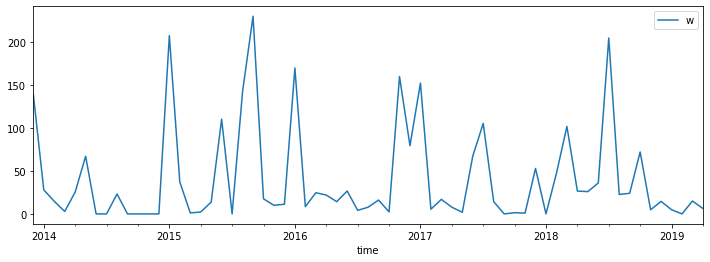

In [48]:
dftm.plot(figsize=(12,4))

## decompose

In [49]:
man=seasonal_decompose(dftm['w'])

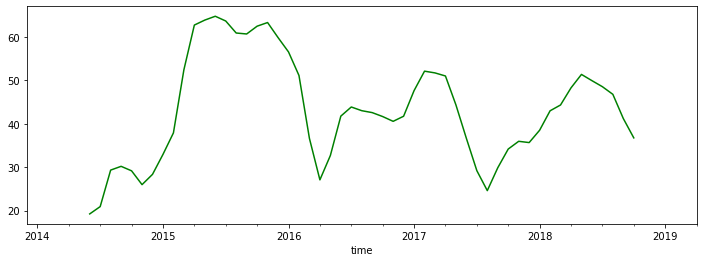

In [50]:
man.trend.plot(figsize=(12,4),color='g')

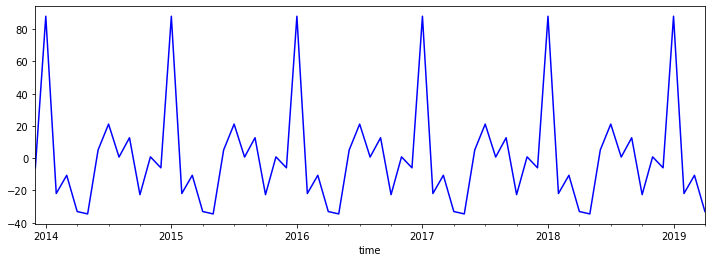

In [51]:
man.seasonal.plot(figsize=(12,4),color='b')

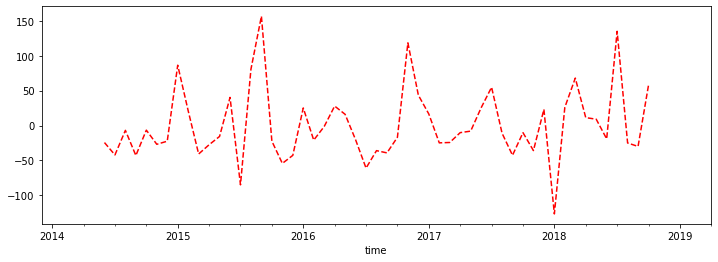

In [52]:
man.resid.plot(figsize=(12,4),color='r',style='--')

## richter tor-SARIMA

In [62]:
dfm=pd.read_csv('df0new.csv')
dfm['time']=pd.to_datetime(dfm['time'])
dfm.sort_values('time',inplace=True)
dfm.reset_index(inplace=True,drop=True)
dfm.set_index('time',inplace=True)
dfm['w']=10**dfm['Mpf']
dfm=dfm[['w']]
dftm=dfm.resample(rule='MS').sum()
dftm['w']=dftm['w']/100

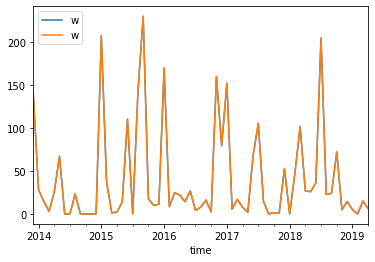

In [63]:
ax=dftm.plot()
dftm.plot(ax=ax)

In [64]:
train_size = int(len(dftm) * 0.7)
train, test = dftm[0:train_size], dftm[train_size:]
model = sm.tsa.statespace.SARIMAX(train,order=(0,1,2),seasonal_order=(2, 1,0, 10),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
results=model.fit()
dftm['predict'] = results.predict(start=test.index[0] , end=test.index[-1],typ='levels', dynamic=False)
dftm['fittedvalues']=results.fittedvalues
#test
print(results.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   w   No. Observations:                   45
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 10)   Log Likelihood                 -77.447
Date:                             Sat, 05 Sep 2020   AIC                            164.893
Time:                                     10:28:24   BIC                            168.089
Sample:                                 12-01-2013   HQIC                           164.597
                                      - 08-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3417      0.613     -0.558      0.577      -1.543       0.859
ma.L2         -0.0252      

Text(0, 0.5, 'Seismic incidents')

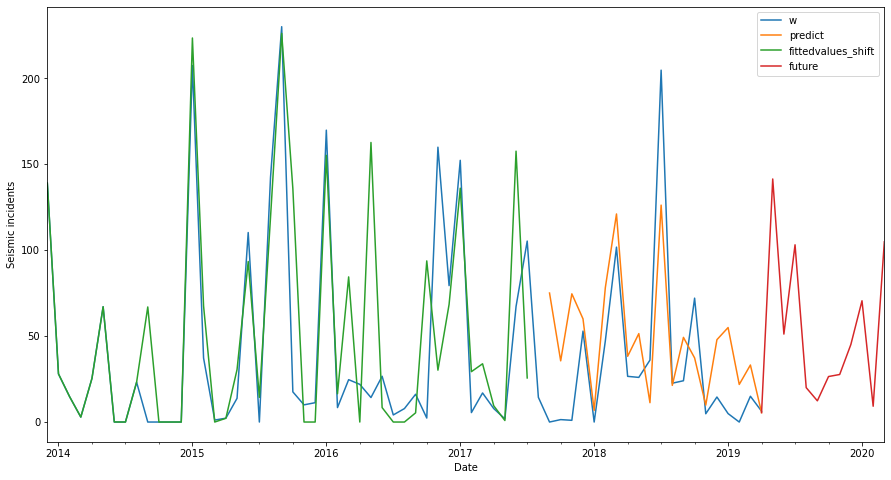

In [65]:
from pandas.tseries.offsets import DateOffset
future_dates = [dftm.index[-1] + DateOffset(months=x) for x in range(0,12) ]
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=dftm.columns)
future_df = pd.concat([dftm,future_dates_df])
future_df['future'] = results.predict(start = 64, end = 76)
future_df['fittedvalues_shift'] = future_df['fittedvalues'].shift(-1)
future_df['fittedvalues_shift'] = np.where(future_df['fittedvalues_shift']<0, 0,future_df['fittedvalues_shift'])
future_df['predict'] = np.where(future_df['predict']<0, 0,future_df['predict'])
future_df['future'] = np.where(future_df['future']<0, 0,future_df['future'])
future_df[['w','predict','fittedvalues_shift','future']].plot(figsize=(15,8))
plt.xlabel('Date')
plt.ylabel('Seismic incidents')

## SARIMAX

In [153]:
dfm=pd.read_csv('df0new.csv')
dfm['time']=pd.to_datetime(dfm['time'])
dfm.sort_values('time',inplace=True)
dfm.reset_index(inplace=True,drop=True)
dfm.set_index('time',inplace=True)
dfm['w']=10**dfm['Mpf']
dfm=dfm[['w']]
dftm=dfm.resample(rule='MS').sum()
dftm['w']=dftm['w']/100
sigma=pd.read_csv('sigma2_1.csv')
sigma['well_date']=pd.to_datetime(sigma['well_date'])
sigma.sort_values('well_date',inplace=True)
sigma.reset_index(inplace=True,drop=True)
sigma.set_index('well_date',inplace=True)
sigmawell=sigma[['well_name',
       'well_uwi', 'well_lat', 'well_lon', 'well_Dep']]
sigmawell=sigmawell.drop_duplicates()
sigmawell=sigmawell[['well_uwi']]
sigmawellt=sigmawell.resample(rule='MS').count()
merged = dftm.merge(sigmawellt, left_index=True, right_index=True, how='left')
merged['well_uwi'] = merged['well_uwi'].fillna(0)

                                 Statespace Model Results                                 
Dep. Variable:                                  w   No. Observations:                   45
Model:             SARIMAX(0, 1, 2)x(2, 1, 0, 10)   Log Likelihood                -181.741
Date:                            Wed, 24 Jun 2020   AIC                            375.481
Time:                                    21:55:51   BIC                            384.640
Sample:                                12-01-2013   HQIC                           378.605
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
well_uwi      32.1268      3.883      8.274      0.000      24.517      39.737
ma.L1         -1.1975      0.179   

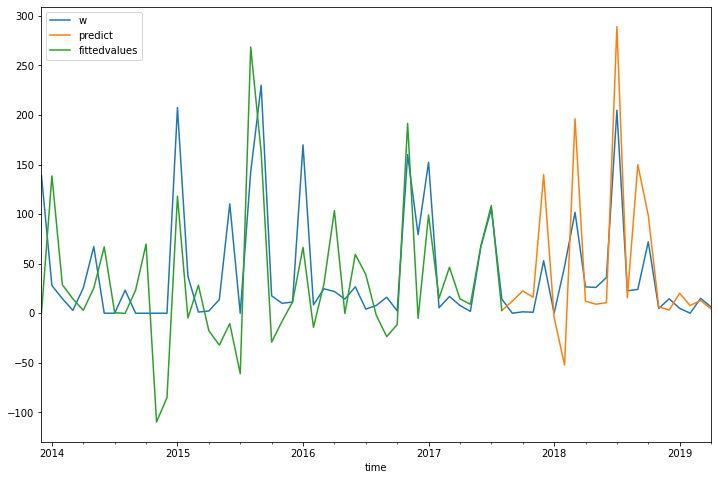

In [154]:
train=merged[0:45]
test=merged[45:65]
model = SARIMAX(train['w'],exog=train['well_uwi'],order=(0,1,2),seasonal_order=(2,1,0,10),enforce_invertibility=False)
results = model.fit()
merged['predict'] = results.predict(start=test.index[0]-1, end=test.index[-1],exog=test[['well_uwi']], dynamic=False)
merged['fittedvalues']=results.fittedvalues
merged[['w','predict','fittedvalues']].plot(figsize=(12,8))
print(results.summary())



    

Text(0, 0.5, 'Seismic incidents')

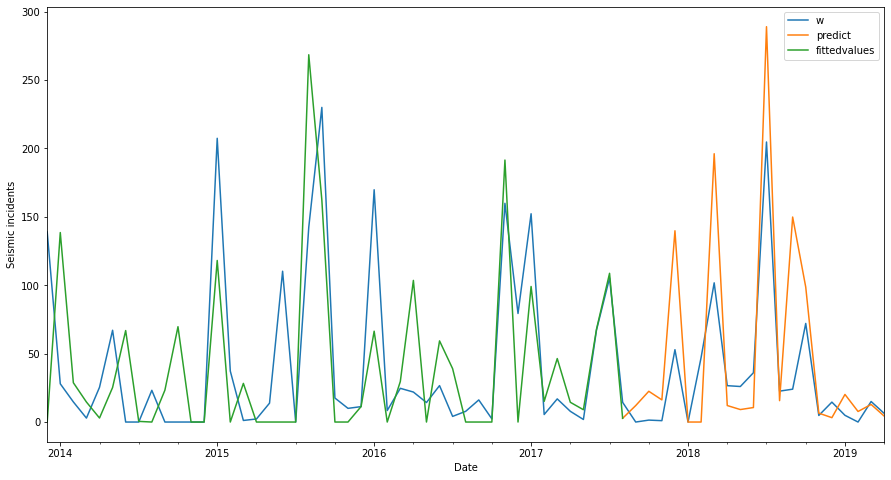

In [155]:
merged['fittedvalues'] = np.where(merged['fittedvalues']<0, 0,merged['fittedvalues'])
merged['predict'] = np.where(merged['predict']<0, 0,merged['predict'])
#merged['fittedvalues'] =merged['fittedvalues'].shift(-1)
merged[['w','predict','fittedvalues']].plot(figsize=(15,8))
plt.xlabel('Date')
plt.ylabel('Seismic incidents')

## SARIMAX_all wells

In [176]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima 
import warnings
warnings.filterwarnings("ignore")
dfm=pd.read_csv('df0new.csv')
dfm['time']=pd.to_datetime(dfm['time'])
dfm.sort_values('time',inplace=True)
dfm.reset_index(inplace=True,drop=True)
dfm.set_index('time',inplace=True)
dfm['w']=10**dfm['Mpf']
dfm=dfm[['w']]
dftm=dfm.resample(rule='MS').sum()
dftm['w']=dftm['w']/100
well=pd.read_csv('well_cluster0_for_sarimax.csv')
wellt=time_index(well)
wellt=resample_data_count(wellt)
wellt=wellt[1:]
wellt['Mpf']=dftm['w']

In [177]:
train=wellt[0:45]
test=wellt[45:65]
forecast=wellt[45:]

In [178]:
model = SARIMAX(train['Mpf'],exog=train['number of fractures'],order=(0,1,0),seasonal_order=(2,1,0,10),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                Mpf   No. Observations:                   45
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 10)   Log Likelihood                -203.084
Date:                            Thu, 25 Jun 2020   AIC                            414.167
Time:                                    01:03:28   BIC                            420.273
Sample:                                12-01-2013   HQIC                           416.249
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
number of fractures    -0.5665      1.524     -0.372      0.710      -3.554       2.421
ar.S.L10               -0.7033      0.166     -4.227      0.000      -1.029      -0.377
ar.S.L20               -0.7278      0.134     -5.433      0.000      -0.990      -0.465
sigma2               5514.7656   2000.732      2.756      0.006    1593.403    9436.128
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 1.97
Prob(Q):                               nan   Prob(JB):                         0.37
Heteroskedasticity (H):               0.96   Skew:                            -0.55
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [179]:

wellt['predict'] = results.predict(start=test.index[0]-1, end=test.index[-1],exog=test[['number of fractures']], dynamic=False)

wellt['fittedvalues']=results.fittedvalues
wellt['fittedvalues'] = np.where(wellt['fittedvalues']<0, 0,wellt['fittedvalues'])
wellt['predict'] = np.where(wellt['predict']<0, 0,wellt['predict'])
wellt['future']=results.predict(start=forecast.index[0]-1, end=forecast.index[-1],exog=forecast[['number of fractures']], dynamic=False)
wellt['future'] = np.where(wellt['future']<0, 0,wellt['future'])

Text(0, 0.5, 'Seismic incidents')

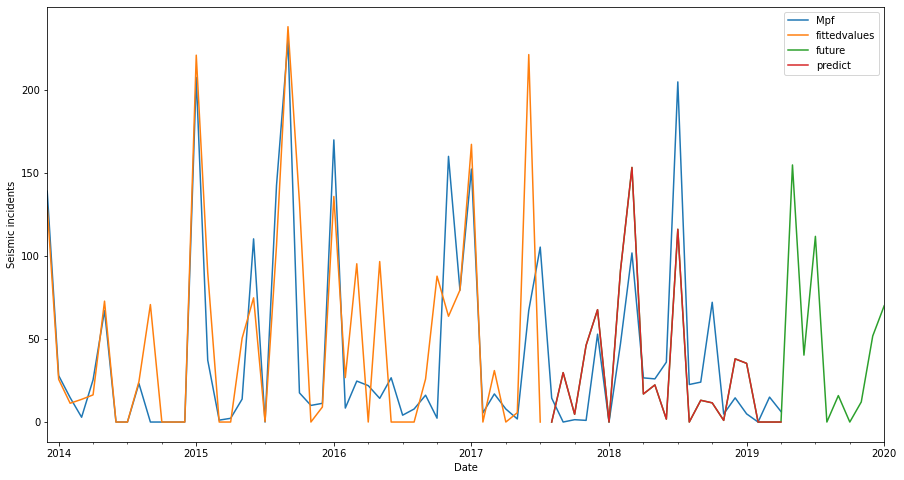

In [180]:
wellt['fittedvalues'] = wellt['fittedvalues'].shift(-1)
wellt[['Mpf','fittedvalues','future','predict']].plot(figsize=(15,8))
plt.xlabel('Date')
plt.ylabel('Seismic incidents')

## profit

In [92]:
from fbprophet import Prophet
dfm=pd.read_csv('df0new.csv')
dfm['time']=pd.to_datetime(dfm['time'])
dfm.sort_values('time',inplace=True)
dfm.reset_index(inplace=True,drop=True)
dfm.set_index('time',inplace=True)
dfm['w']=10**dfm['Mpf']
dfm=dfm[['w']]
dftm=dfm.resample(rule='MS').sum()
dftm['w']=dftm['w']/100
dftm = dftm.reset_index()
dftm.columns = ['ds','y']

In [93]:
train_size = int(len(dftm) * 0.75)
train, test = dftm[0:train_size], dftm[train_size:]

In [94]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=20,freq='MS')
forecast = m.predict(future)
forecast['yhat']=np.ceil(forecast['yhat'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


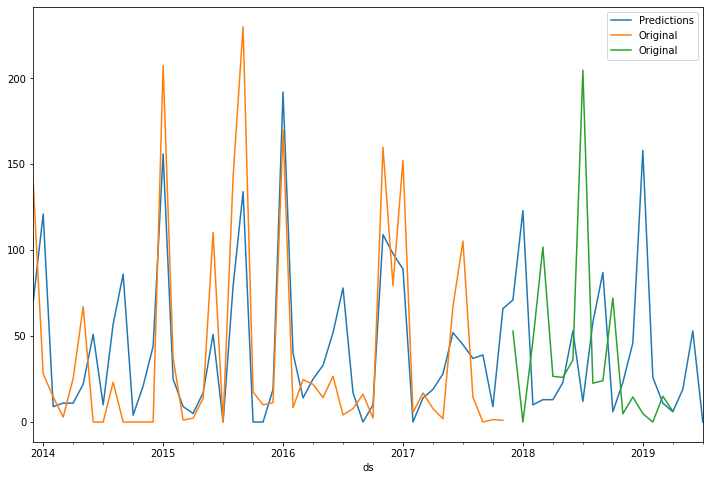

In [250]:
pd.plotting.register_matplotlib_converters()
forecast['yhat'] = np.where(forecast['yhat']<0, 0,forecast['yhat'])
ax=forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
train.plot(x='ds',y='y',label='Original',legend=True,ax=ax)
test.plot(x='ds',y='y',label='Original',legend=True,ax=ax)

In [242]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-12-01,56.243459,10.528877,114.074993,56.243459,56.243459,5.329582,5.329582,5.329582,5.329582,5.329582,5.329582,0.0,0.0,0.0,62.0
1,2014-01-01,56.641581,66.406814,162.050194,56.641581,56.641581,57.240551,57.240551,57.240551,57.240551,57.240551,57.240551,0.0,0.0,0.0,114.0
2,2014-02-01,57.039702,-47.062802,48.801754,57.039702,57.039702,-55.190004,-55.190004,-55.190004,-55.190004,-55.190004,-55.190004,0.0,0.0,0.0,2.0
3,2014-03-01,57.399295,-48.854341,51.614614,57.399295,57.399295,-53.369954,-53.369954,-53.369954,-53.369954,-53.369954,-53.369954,0.0,0.0,0.0,5.0
4,2014-04-01,57.797417,-44.657846,56.632044,57.797417,57.797417,-53.897538,-53.897538,-53.897538,-53.897538,-53.897538,-53.897538,0.0,0.0,0.0,4.0
5,2014-05-01,58.182695,-34.638563,62.389210,58.182695,58.182695,-43.834471,-43.834471,-43.834471,-43.834471,-43.834471,-43.834471,0.0,0.0,0.0,15.0
6,2014-06-01,58.580817,-5.291616,97.652504,58.580817,58.580817,-14.600668,-14.600668,-14.600668,-14.600668,-14.600668,-14.600668,0.0,0.0,0.0,44.0
7,2014-07-01,58.966095,-42.766812,58.648745,58.966095,58.966095,-55.112302,-55.112302,-55.112302,-55.112302,-55.112302,-55.112302,0.0,0.0,0.0,4.0
8,2014-08-01,59.364217,-0.223467,99.449421,59.364217,59.364217,-8.357971,-8.357971,-8.357971,-8.357971,-8.357971,-8.357971,0.0,0.0,0.0,52.0
9,2014-09-01,59.762338,43.991629,144.253922,59.762338,59.762338,33.075087,33.075087,33.075087,33.075087,33.075087,33.075087,0.0,0.0,0.0,93.0


## keras result analysis

In [36]:
##sorting buy well date
sigma=pd.read_csv('sigma2_1.csv')
sigma['well_date']=pd.to_datetime(sigma['well_date'])
sigma.sort_values('well_date',inplace=True)
sigma.reset_index(inplace=True,drop=True)
sigma.set_index('well_date',inplace=True)
sigmawell=sigma[['well_name',
       'well_uwi', 'well_lat', 'well_lon', 'well_Dep']]
sigmawell=sigmawell.drop_duplicates()
sigmawell=sigmawell[['well_uwi']]
sigmawellt=sigmawell.resample(rule='MS').count()

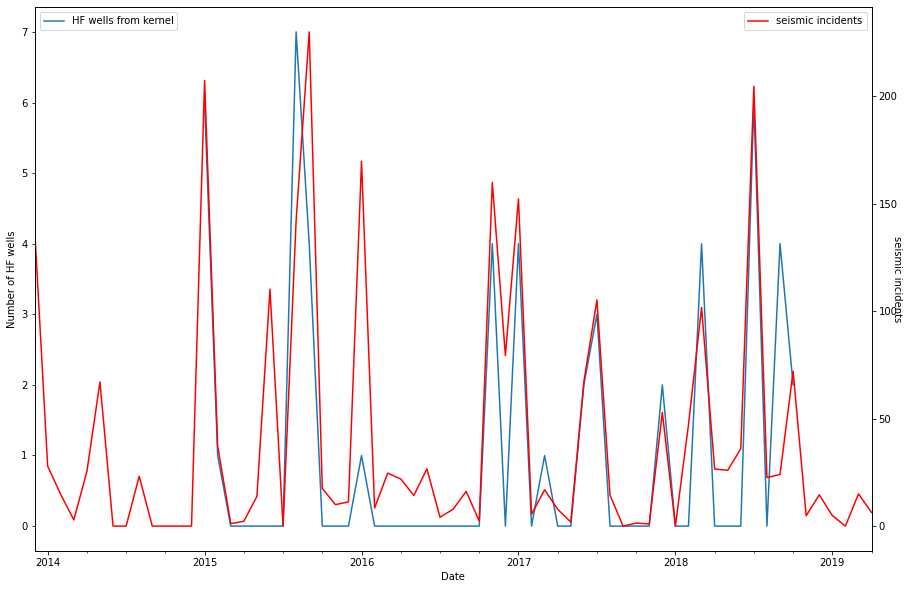

In [37]:
ax=sigmawellt['well_uwi'].plot(figsize=(15,10),label='HF wells from kernel')
plt.legend(labels=['HF wells from kernel'],loc='upper left')
plt.ylabel('Number of HF wells')
plt.xlabel('Date')
ax2 = ax.twinx()
dftm['w'].plot(ax=ax2,color='r')
plt.ylabel('seismic incidents',rotation=270)
plt.legend(labels=['seismic incidents'])

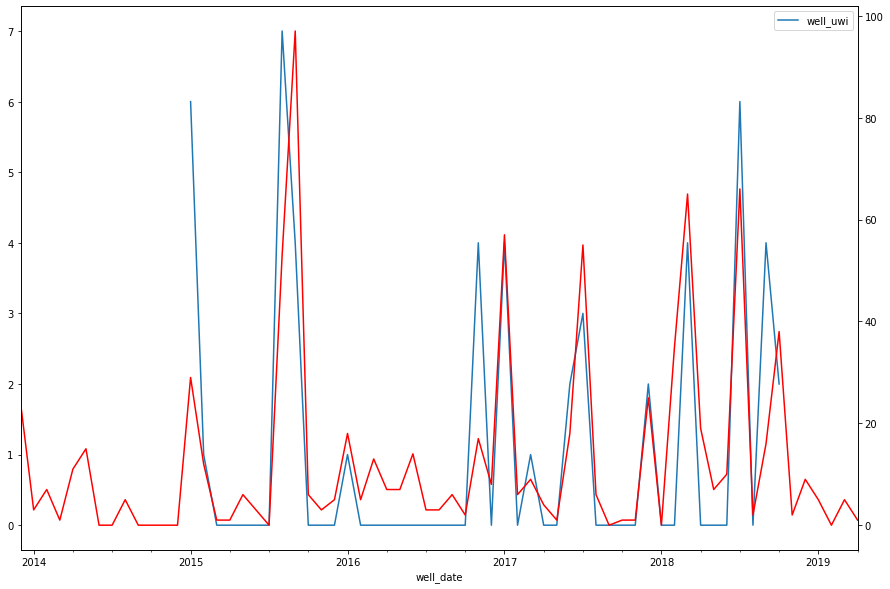

In [88]:
ax=sigmawellt.plot(figsize=(15,10))
ax2 = ax.twinx()
dft['Mpf'].plot(ax=ax2,color='r')

In [10]:
sigmawellt 

,well_uwi
well_date,
2015-01-01,6
2015-02-01,1
2015-03-01,0
2015-04-01,0
2015-05-01,0
2015-06-01,0
2015-07-01,0
2015-08-01,7
2015-09-01,4
